In [12]:
!pip install pmdarima
!pip install prophet
!pip install xgboost

In [13]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from prophet import Prophet
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm  
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import logging
import cmdstanpy

In [32]:
# 2. Load & Parse Data(Load in chunks to avoid memory error)
chunksize = 100000  # adjust if needed
chunks = []

for chunk in pd.read_csv(
    r"C:\Users\FARHAT\Downloads\individual+household+electric+power+consumption/household_power_consumption.txt",
    sep=";",
    low_memory=False,
    na_values="?",
    chunksize=chunksize
):
    chunks.append(chunk)

# Concatenate chunks
df = pd.concat(chunks, ignore_index=True)

# Combine Date + Time into datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors="coerce")
df.set_index('datetime', inplace=True)

# Focus on Global_active_power
df = df[['Global_active_power']].astype(float)

print("Initial dataset shape:", df.shape)
print(df.head())


Initial dataset shape: (2075259, 1)
                     Global_active_power
datetime                                
2006-12-16 17:24:00                4.216
2006-12-16 17:25:00                5.360
2006-12-16 17:26:00                5.374
2006-12-16 17:27:00                5.388
2006-12-16 17:28:00                3.666


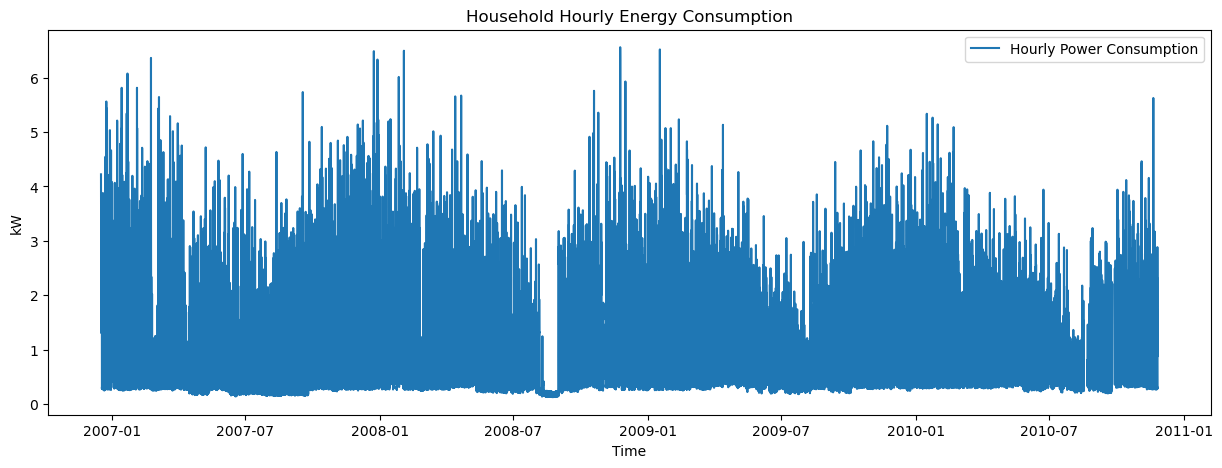

In [33]:
# 3. Resample Time Series (Hourly)
df_resampled = df['Global_active_power'].resample('h').mean()
plt.figure(figsize=(15,5))
plt.plot(df_resampled.index, df_resampled.values, label="Hourly Power Consumption")
plt.title("Household Hourly Energy Consumption")
plt.xlabel("Time")
plt.ylabel("kW")
plt.legend()
plt.show()


In [34]:
# 4. Feature Engineering
df_features = pd.DataFrame({
    "y": df_resampled,
    "hour": df_resampled.index.hour,
    "day_of_week": df_resampled.index.dayofweek,
    "is_weekend": (df_resampled.index.dayofweek >= 5).astype(int)
})

# Handle NaNs (from resampling)
df_features.dropna(inplace=True)

In [35]:
# 5. Train-Test Split
split_point = int(len(df_features)*0.8)
train, test = df_features.iloc[:split_point], df_features.iloc[split_point:]
y_train, y_test = train['y'], test['y']
print("Train size:", len(train), " Test size:", len(test))

Train size: 27334  Test size: 6834


In [36]:
# -------------------------------
# Step 6: ARIMA Model (Daily)
# -------------------------------
print("🔹 Training ARIMA (Daily Data)")

# Resample to daily
df_daily = df['Global_active_power'].resample('D').mean()

# Forward fill missing values
df_daily = df_daily.ffill()

# Explicitly set daily frequency
df_daily = df_daily.asfreq('D')

# Train-test split (80/20)
split_point = int(len(df_daily) * 0.8)
y_train_arima, y_test_arima = df_daily.iloc[:split_point], df_daily.iloc[split_point:]

# Auto ARIMA to find best order
print("🔍 Finding best ARIMA order...")
auto_model = pm.auto_arima(
    y_train_arima,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    max_p=5,
    max_q=5
)
print("✅ Best ARIMA order found:", auto_model.order)

# Fit ARIMA
warnings.simplefilter('ignore', ConvergenceWarning)
model_arima = ARIMA(y_train_arima, order=auto_model.order)
model_fit = model_arima.fit()

# Forecast
forecast_arima = model_fit.forecast(steps=len(y_test_arima))


🔹 Training ARIMA (Daily Data)
🔍 Finding best ARIMA order...
✅ Best ARIMA order found: (4, 0, 3)


In [37]:
# -------------------------------
# Step 7: Prophet Model
# -------------------------------
logging.getLogger('cmdstanpy').disabled = True
print("🔹 Training Prophet...")

# -------------------------------
# Resample to daily to reduce rows
# -------------------------------
prophet_df = df['Global_active_power'].resample('D').mean().ffill().reset_index()
prophet_df.rename(columns={'datetime':'ds', 'Global_active_power':'y'}, inplace=True)

# Train-test split (80/20)
split_point = int(len(prophet_df) * 0.8)
train_prophet = prophet_df.iloc[:split_point]
test_prophet = prophet_df.iloc[split_point:]

# -------------------------------
# Fit Prophet
# -------------------------------
model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
model_prophet.fit(train_prophet)

# Create future dataframe only for test period
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast_prophet_df = model_prophet.predict(future)

# Extract forecast and test values
forecast_prophet = forecast_prophet_df['yhat'][-len(test_prophet):].values
y_test_prophet = test_prophet['y'].values

🔹 Training Prophet...


In [38]:
# -------------------------------
# Step 8: XGBoost Model (Optional)
# -------------------------------
# If you implement XGBoost, ensure train/test sets are ready
# For now, we will skip XGBoost in evaluation if not available
use_xgb = False  # Set True if XGBoost forecast is ready
if use_xgb:
    # forecast_xgb = ... # define your XGBoost forecast here
    # y_test_xgb = ...   # define your XGBoost test target here
    pass

In [39]:
# -------------------------------
# Step 9: Evaluation
# -------------------------------
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Align forecasts
forecast_arima_aligned = pd.Series(forecast_arima, index=y_test_arima.index)
forecast_prophet_aligned = pd.Series(forecast_prophet, index=y_test_arima.index)

results = {
    "ARIMA": evaluate(y_test_arima, forecast_arima_aligned),
    "Prophet": evaluate(y_test_prophet, forecast_prophet_aligned)
}

# Include XGBoost if available
if use_xgb:
    forecast_xgb_aligned = pd.Series(forecast_xgb[-len(y_test_xgb):], index=y_test_arima.index)
    results["XGBoost"] = evaluate(y_test_xgb, forecast_xgb_aligned)

results_df = pd.DataFrame(results, index=["MAE", "RMSE"]).T
print("\n📊 Model Performance Comparison:")
print(results_df)


📊 Model Performance Comparison:
              MAE      RMSE
ARIMA    0.511489  0.584996
Prophet  0.193812  0.260456


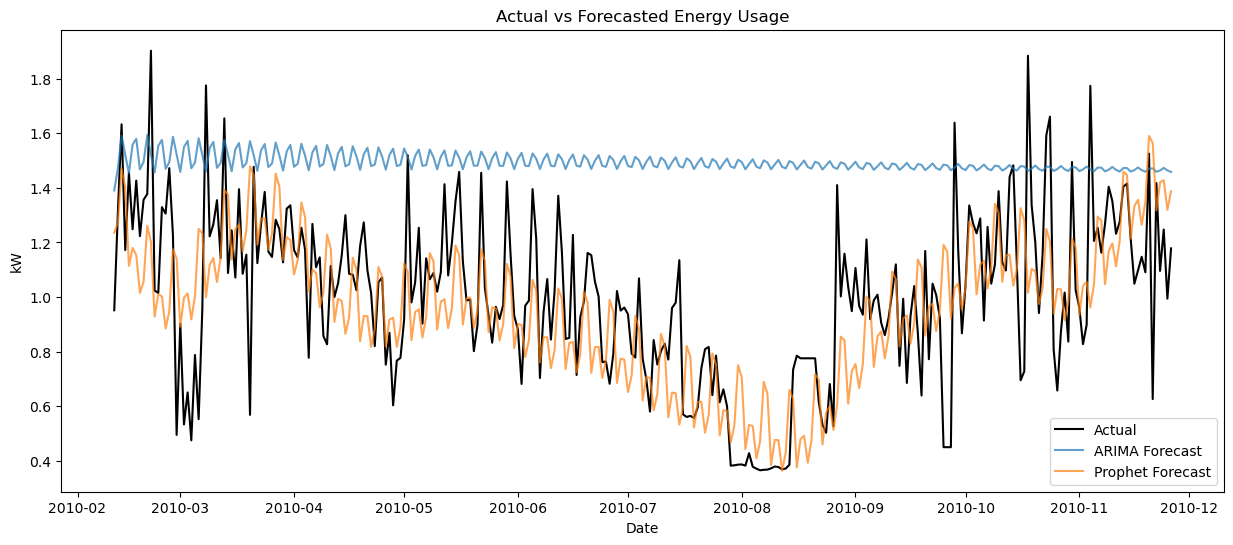

In [40]:
# -------------------------------
# Step 10: Visualization
# -------------------------------
plt.figure(figsize=(15,6))
plt.plot(y_test_arima.index, y_test_arima.values, label="Actual", color="black")
plt.plot(forecast_arima_aligned.index, forecast_arima_aligned.values, label="ARIMA Forecast", alpha=0.7)
plt.plot(forecast_prophet_aligned.index, forecast_prophet_aligned.values, label="Prophet Forecast", alpha=0.7)

if use_xgb:
    plt.plot(forecast_xgb_aligned.index, forecast_xgb_aligned.values, label="XGBoost Forecast", alpha=0.7)

plt.title("Actual vs Forecasted Energy Usage")
plt.xlabel("Date")
plt.ylabel("kW")
plt.legend()
plt.show()